### Data Acquisition

In [1]:
import pandas as pd 
import json
import re
from elasticsearch import Elasticsearch  # pip install elasticsearch==5.5.3
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.ticker import MaxNLocator
import math
import ast

import plotly.express as px

import os

#### Elasticsearch query

In [8]:
dev_unit_ids= ["34a1a417-7db2-4a2f-a706-2e1027c2576b", "38f13f51-9d97-4476-8cd6-16da17997153",
               "5cee3d15-0b1d-4324-a2f4-a0822f20eab9", "a03e9dd9-cdc2-407c-b78d-4fdb660b7909",
               "b1999387-2473-4f9e-a551-e2909445b6fe"]

qa_unit_ids = ["9c20e13e-126f-42b9-9a35-ce7cdd16e936", "9e46cf6b-184d-4d36-a00c-93f062fc26f2", 
               "b1630858-3406-4975-8a0f-0a6ff230fa4b", "c8f2794a-4737-4633-9f3f-7eb0e4d8cba9"]

comm_unit_ids=[ "05999a85-c724-4efd-a6b2-9dea42673cd1", "1764c3be-77e4-4b0b-9ef7-2b49f795c2ef"
                "29819f2b-3082-4e98-b8ff-656b568546b8", "46d27580-0a8d-46b3-b30e-efcd16678f6a",
                "55e54a00-dac5-4620-bd9b-debacdd57445", "5dd21b13-fd38-4590-bc2a-0644f3e88ada", 
                "65357241-78a7-4e0b-8dc2-af12c3ee1723", "68d8b8f8-59a7-4349-aace-396e8252004d", 
                "8121aa82-3c63-4e21-944b-20ea906c13ce", "96036915-36ac-4304-aa70-f05e70e571a3",
                "995d3ae1-8eee-46f1-901b-eb73bdc5e7ea", "9acf2ab5-801d-4756-8015-b85e5c45624e"
                "a1882fcc-08f4-4ab0-8ba1-41b45ec84209", "ab539d08-335e-4686-85e4-856c091b77d2",
                "cacdc34e-7127-4f11-9e52-f92b73e6d12e", "cfca43d2-38b4-4651-9a6c-cff62e7944e4",
                "df7d947c-cc9e-4789-acf6-f29652f5d8fe", "e4191dfb-c598-4a99-bd83-33374632bcef",
                "fdd3cd9a-dcf0-4d6f-8288-13a28573e53f", "fe374265-b9b5-4025-b993-c4e33c213f0b"]

too_many_records = ["68d8b8f8-59a7-4349-aace-396e8252004d", "cfca43d2-38b4-4651-9a6c-cff62e7944e4", "5dd21b13-fd38-4590-bc2a-0644f3e88ada"] 

"""
Peter: b1630858-3406-4975-8a0f-0a6ff230fa4b   QA   (data starting from nov 12)
Henrik: 9e46cf6b-184d-4d36-a00c-93f062fc26f2 QA   (data starting from nov 12)
TAB: 68d8b8f8-59a7-4349-aace-396e8252004d  Community  (data starting from nov 1, vehicle switch around nov 12)
"""

'\nPeter: b1630858-3406-4975-8a0f-0a6ff230fa4b   QA   (data starting from nov 12)\nHenrik: 9e46cf6b-184d-4d36-a00c-93f062fc26f2 QA   (data starting from nov 12)\nTAB: 68d8b8f8-59a7-4349-aace-396e8252004d  Community  (data starting from nov 1, vehicle switch around nov 12)\n'

In [3]:
# Structures
obd_mapping = {
    "@vid": "vid",
    "@uid": "unit_id",
    "obd.": "not_replaced",
    "@ts": "detected",
    "@t": "obd_parameter",
    "@rec": "recorded"
}

batch_mapping = {
    "batch.bytes": "bytes",
    "@vid": "vid",
    "@uid": "unit_id",
    "@t": "batch_event",
    "batch.event_count": "event_count",
    "batch.bytes_decompressed": "bytes_decompressed",
    "batch.data_count": "data_count",
    "@ts": "detected",
    "@rec": "recorded"
}

track_mapping = {
    "track.pos.sog": "pos_sog",
    "@vid": "vid",
    "track.pos.cog": "pos_cog",
    "@t": "track.pos",
    "track.pos.loc": "lat_long",
    "track.pos.nsat": "pos_nsat",
    "track.pos.alt": "pos_alt",
    "@ts": "detected",
    "@uid": "unit_id",
    "@rec": "recorded"
}

event_mapping = {
    "@uid": "unit_id",
    "@tag": "event_tag",
    "@t":   "event_parameter",
    "@ts":  "detected",
    "@rec": "recorded"
}

std_mapping = {
  '@uid': 'unit_id',
  '@t': 'std_parameter',
  '@ts': 'detected',
  '@rec': 'recorded'
}


In [10]:
for uuid_string in too_many_records:
    es = Elasticsearch("http://localhost:9200") # 9200 community, dev / 9202 QA
    start = "2025-01-01T00:00:00.000000Z"  # ISO format YYYY-MM-DD
    end   = "2025-01-24T00:00:00.000000Z"

    file_path = f"csv_data/{uuid_string}/output.json"

    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Query to match documents with specified @id and @ts conditions
    query = {
        "query": {
            "bool": {
                "must": [
                    {"term": {"@uid": uuid_string}},  # Match exact UUID
                    {"range": {"@ts": {"gt": start, "lt":end}}} # To use end timestamp use {"gt": start, "lt": end}
                ]
            }
        },
        "sort": [
        {
        "@ts": {
            "order": "asc"
        }
        }
    ]
    }

    # Parameters
    index_name = "c*"  # Replace with your index name/pattern

    # Start the initial search request with scroll enabled
    response = es.search(
        index=index_name,
        body=query,
        scroll="2m",
        size=1000
    )

    scroll_id = response["_scroll_id"]
    hits = response["hits"]["hits"]
    total_records = response["hits"]["total"]

    # Initialize an empty list to collect all records
    all_records = []

    print(f"Processing {total_records} record for unit {uuid_string}...")

    max_records = 30000000
    min_records = 500

    if ( min_records < total_records ) and (total_records < max_records) :

        # Loop through each batch of documents
        while hits:
            # Add only the "_source" part of each document to the all_records list
            all_records.extend([hit["_source"] for hit in hits])
            
            # Fetch the next batch of documents
            response = es.scroll(scroll_id=scroll_id, scroll="2m")   #270,000 records take around 1 min in community cloud
            hits = response["hits"]["hits"]

        # Write the collected records to a JSON file as a valid JSON array
        with open(file_path, "w") as f:
            json.dump(all_records, f, indent=2)

        print("===================")
    elif (total_records >= max_records): 
        print(f"Too many records for unit_id: {uuid_string}, skipping...")
        print("===================")
    else:
        print(f"Not enough records for unit_id: {uuid_string}, skipping...")
        print("===================")

Processing 1745683 record for unit 68d8b8f8-59a7-4349-aace-396e8252004d...
Processing 631051 record for unit cfca43d2-38b4-4651-9a6c-cff62e7944e4...
Processing 612369 record for unit 5dd21b13-fd38-4590-bc2a-0644f3e88ada...


In [ ]:
# Write the collected records to a JSON file as a valid JSON array
# Get a list of all directories in the current path
directories = [d for d in os.listdir('./csv_data')]
print(directories)

for dir in directories:
    current_path = 'csv_data/'+dir+'/'

    obd_records = []
    batch_records = []
    track_records = []
    event_records = []
    std_records = []
    opt_records = []

    with open(current_path+'output.json', 'r') as json_file:
        input_file = json.load(json_file)
        for record in input_file:
            if 'obd.' in record['@t']:
                obd_records.append(record)
            elif 'track.' in record['@t']:
                track_records.append(record)
            elif 'std.' in record['@t']:
                std_records.append(record)
            elif 'event.' in record['@t']:
                event_records.append(record)
            elif 'batch' in record['@t']:
                batch_records.append(record)
            elif 'opt' in record['@t']:
                opt_records.append(record)
            else:
                print(f"Unrecognized record format {record}")       
        
        # verify there are no missing records
        records_match = (len(obd_records) +  len(batch_records) + len(track_records) + len(event_records) + len(std_records) + len(opt_records) == len(input_file))

        if records_match:
            print("CSV records length match!")
        else:
            print("Warning! csv records length mismatch")

        records = [('obd_export', obd_records), ('batch_export', batch_records), 
        ('track_export',track_records), ('event_export',event_records),
        ('std_export', std_records),('opt_export', opt_records) ]

        for df_name, values in records:
            temp_df = pd.DataFrame(values)
            temp_df.to_csv(current_path+df_name+'.csv')

        del(temp_df)

['c8f2794a-4737-4633-9f3f-7eb0e4d8cba9', '9e46cf6b-184d-4d36-a00c-93f062fc26f2', 'b1630858-3406-4975-8a0f-0a6ff230fa4b', '9c20e13e-126f-42b9-9a35-ce7cdd16e936']
CSV records length match!
CSV records length match!
CSV records length match!
CSV records length match!


#### Auxiliary functions

In [28]:
def plot_column(df, col_name, start_ts=None, end_ts=None):
    """
    Plots a specified column from the DataFrame over time, optionally within a time range.
    
    Parameters:
    - df: DataFrame containing the data
    - col_name: Name of the column to plot
    - start_ts: Optional, start timestamp to filter the data
    - end_ts: Optional, end timestamp to filter the data
    """
    if start_ts is not None:
        df = df[df['@ts'] >= start_ts]
    if end_ts is not None:
        df = df[df['@ts'] <= end_ts]
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['@ts'], df[col_name], marker='o', linestyle='-')
    plt.title(f'{col_name}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{col_name} values')
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Set x-axis to show only a few timestamps if there are too many
    ax = plt.gca()  # Get the current axis
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit to 10 x-ticks, adjust as needed
    
    plt.tight_layout()
    plt.show()

In [29]:
def plot_grid(o_df, columns):
    """
    Plots each column in the columns list in an N x 3 grid, where N is calculated based on the number of columns.

    Parameters:
    - o_df: pandas DataFrame containing the data with a timestamp column '@ts'.
    - columns: list of column names to plot.
    """
    num_columns = len(columns)
    # Calculate the number of rows needed for an N x 3 grid
    num_rows = math.ceil(num_columns / 3)
    
    # Set up the figure with a grid of subplots
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows), sharex=True)
    axes = axes.flatten()  # Flatten to simplify indexing

    # Plot each column in the grid
    for i, col_name in enumerate(columns):
        axes[i].plot(o_df['@ts'], o_df[col_name], marker='o', linestyle='-')
        axes[i].set_title(f'{col_name}')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(f'{col_name} values')
        axes[i].grid(True)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    
        # Set x-axis to show only a few timestamps if there are too many    ax = plt.gca()  # Get the current axis
        axes[i].xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit to 10 x-ticks, adjust as needed
        
    # Hide any unused subplots in the grid
    for j in range(i + 1, num_rows * 3):
        axes[j].axis('off')
    
    # Adjust layout for spacing
    plt.tight_layout()
    plt.show()

### EDA

#### Inspect all dataframes

For each dataframe:  
1. Inspect each column 
   1. Determine: (column_name, numerical, categorical, null_values, unique_values, values_range)
   2. Write column results to a dataframe
2. Write results to a file

In [48]:
def inspect_dataframe( df:pd.DataFrame, df_name ):
    min_timestamp = None
    max_timestamp = None

    results = []

    def new_row():
        return {'df': df_name, 'col_name': None, 
                'data_type': None, 'total_rows':None, 'not_null_rows':None,
                'unique_count': None, 'values_range':None}
    

    all_cols = filter( lambda x: '@' not in x, df.columns.to_list())
    cols_numeric = list(set(all_cols).intersection(set(df.describe().columns)))
    cols_categorical =  list( set(all_cols) - set(df.describe().columns) )
    
    for col in df.columns:
        if '@' in col:
            if 'ts' in col:
                stamps = pd.to_datetime(df[col])
                min = stamps.min()
                max = stamps.max()
                if min_timestamp is None:
                    min_timestamp = min 
                
                if max_timestamp is None:
                    max_timestamp = max
                
                if min_timestamp and (min < min_timestamp):
                    min_timestamp = min
                
                if max_timestamp and (max_timestamp < max):
                    max_timestamp = max
        else:
            row = new_row()
            row['df'] = df_name
            row['col_name'] = col
            row['data_type'] = 'numeric' if col in cols_numeric else 'category'
            row['total_rows'] = len(df) 
            row['not_null_rows'] = df[col].notna().count()
            row['unique_count'] = len(df[col].unique())
            if row['data_type'] == 'numeric':
                min = df[col].min()
                max = df[col].max()
                if min < max:
                    row['values_range'] = f"{round(min)} , {round(max)}"
                else:
                    row['values_range'] = f"{min}"
            else:
                value_list = df[col].value_counts().index.to_list()
                if 'lat' in value_list[0]: 
                    row['values_range'] = value_list[:2]
                else:
                    row['values_range'] = value_list
            results.append(row)
    print( df_name, min_timestamp, max_timestamp)
    
    return results

In [51]:
csv_files = ['batch_export.csv', 'event_export.csv', 
            'obd_export.csv', 'std_export.csv', 'track_export.csv',
            'opt_export.csv']

all_results = []
for csv in csv_files:
    try:
        df = pd.read_csv(csv, index_col=False, low_memory=False) #'./csv_data/peter_1311/'+
        df.drop(['Unnamed: 0', '@vid', '@uid'], axis=1, inplace=True)
        all_results += inspect_dataframe(df, csv.split('.')[0])
    except KeyError:
            print(f"Failed to parse {df_name} dataframe ")
qa_df = pd.DataFrame(all_results)

batch_export 2024-11-23 00:00:00.478772+00:00 2024-11-24 23:59:55.623935+00:00
event_export 2024-11-23 02:01:36.020000+00:00 2024-11-24 23:55:08.020000+00:00
obd_export 2024-11-23 08:42:06.030000+00:00 2024-11-23 19:10:54.070000+00:00
std_export 2024-11-23 00:00:00.010000+00:00 2024-11-24 23:55:08.020000+00:00
track_export 2024-11-23 00:00:00.010000+00:00 2024-11-24 23:55:08.020000+00:00
Failed to parse opt_export dataframe 


In [14]:
qa_df.head()

df                  col_name data_type  total_rows  \
0  batch_export               batch.bytes   numeric        3919   
1  batch_export         batch.event_count   numeric        3919   
2  batch_export  batch.bytes_decompressed   numeric        3919   
3  batch_export          batch.data_count   numeric        3919   
4    obd_export           obd.bat.voltage   numeric       96962   

   not_null_rows  unique_count values_range  
0           3919             1            0  
1           3919             5        0 , 4  
2           3919             1            0  
3           3919             6       0 , 52  
4          96962            16      12 , 15

In [54]:
qa_df.col_name.unique()

array(['batch.bytes', 'batch.event_count', 'batch.bytes_decompressed',
       'batch.data_count', 'obd.bat.voltage', 'obd.bat.state',
       'obd.bat.level', 'obd.oem_battery_temperature.value',
       'obd.obd_oem_total_mileage.value',
       'obd.oem_hv_battery_max_cell_temperature.value',
       'obd.oem_battery_charge_level.value',
       'obd.oem_battery_charge_state.value', 'obd.number_of_dtc.value',
       'obd.hybrid_system_voltage.value', 'obd.rpm.value',
       'obd.speed.value', 'obd.engine_load.value',
       'obd.throttle_pos.value', 'obd.control_module_voltage.value',
       'obd.hybrid_battery_pack_life.value',
       'obd.hybrid_system_current.value',
       'obd.oem_hv_battery_min_cell_voltage.value',
       'obd.oem_hv_battery_max_cell_voltage.value',
       'obd.oem_hv_battery_current.value',
       'obd.oem_hv_battery_voltage.value',
       'obd.oem_hv_battery_max_energy.value',
       'obd.oem_hv_battery_measured_energy.value',
       'obd.oem_hv_battery_lifetime_p

In [59]:
qa_df[(qa_df.values_range == "0") | (qa_df.values_range.str.contains("0.0") )]

df                   col_name data_type  total_rows  \
0   batch_export                batch.bytes   numeric        4090   
2   batch_export   batch.bytes_decompressed   numeric        4090   
6     obd_export              obd.bat.level   numeric       89286   
10    obd_export      obd.engine_load.value   numeric       89286   
27    obd_export    obd.number_of_dtc.value   numeric       89286   
29    obd_export     obd.throttle_pos.value   numeric       89286   
33    std_export   std.total_odometer.value   numeric       85790   
37    std_export  std.battery_voltage.value   numeric       85790   
38    std_export  std.battery_current.value   numeric       85790   
43    std_export    std.battery_level.value   numeric       85790   
49    std_export    std.trip_odometer.value   numeric       85790   
53    std_export        std.eco_score.value   numeric       85790   
60  track_export               track.pos.pr   numeric        3957   

    not_null_rows  unique_count         values_range  
0            4090             1                    0  
2            4090             1                    0  
6           89286             2                  0.0  
10          89286             2                100.0  
27          89286             2                  0.0  
29          89286             2                  0.0  
33          85790           274  49177000 , 49482000  
37          85790             2                  0.0  
38          85790             2                  0.0  
43          85790             2                  0.0  
49          85790            40            0 , 38000  
53          85790             2                 10.0  
60           3957             2                  0.0

In [60]:
qa_df['negative'] = qa_df.values_range.str.contains("-")

In [61]:
qa_df[qa_df.negative == True]

df                          col_name data_type  total_rows  \
16    obd_export   obd.hybrid_system_current.value   numeric       89286   
19    obd_export  obd.oem_hv_battery_current.value   numeric       89286   
25    obd_export            obd.coolant_temp.value   numeric       89286   
34    std_export    std.accelerometer_axis_x.value   numeric       85790   
35    std_export    std.accelerometer_axis_y.value   numeric       85790   
36    std_export    std.accelerometer_axis_z.value   numeric       85790   
59  track_export                     track.pos.alt   numeric        3957   

    not_null_rows  unique_count  values_range negative  
16          89286          1328  -4278 , 1739     True  
19          89286          1308    -174 , 426     True  
25          89286             2         -41.0     True  
34          85790           455    -339 , 426     True  
35          85790           536    -417 , 423     True  
36          85790           202    -140 , 360     True  
59           3957           114      -31 , 91     True

In [22]:
qa_df.df.unique()

array(['batch_export', 'obd_export', 'std_export', 'track_export',
       'opt_export'], dtype=object)

In [23]:
qa_df[qa_df.df=='obd_export']

df                                        col_name data_type  \
4   obd_export                                 obd.bat.voltage   numeric   
5   obd_export                                   obd.bat.state   numeric   
6   obd_export                                   obd.bat.level   numeric   
7   obd_export               obd.oem_battery_temperature.value   numeric   
8   obd_export                 obd.obd_oem_total_mileage.value   numeric   
9   obd_export   obd.oem_hv_battery_max_cell_temperature.value   numeric   
10  obd_export              obd.oem_battery_charge_level.value   numeric   
11  obd_export              obd.oem_battery_charge_state.value  category   
12  obd_export                         obd.number_of_dtc.value   numeric   
13  obd_export                 obd.hybrid_system_voltage.value   numeric   
14  obd_export                                   obd.rpm.value   numeric   
15  obd_export                                 obd.speed.value   numeric   
16  obd_export                           obd.engine_load.value   numeric   
17  obd_export                          obd.throttle_pos.value   numeric   
18  obd_export                obd.control_module_voltage.value   numeric   
19  obd_export              obd.hybrid_battery_pack_life.value   numeric   
20  obd_export                 obd.hybrid_system_current.value   numeric   
21  obd_export       obd.oem_hv_battery_min_cell_voltage.value   numeric   
22  obd_export       obd.oem_hv_battery_max_cell_voltage.value   numeric   
23  obd_export                obd.oem_hv_battery_current.value   numeric   
24  obd_export                obd.oem_hv_battery_voltage.value   numeric   
25  obd_export             obd.oem_hv_battery_max_energy.value   numeric   
26  obd_export        obd.oem_hv_battery_measured_energy.value   numeric   
27  obd_export     obd.oem_hv_battery_lifetime_power_use.value   numeric   
28  obd_export  obd.oem_hv_battery_lifetime_charge_power.value   numeric   
29  obd_export                obd.oem_remaining_distance.value   numeric   
30  obd_export                          obd.coolant_temp.value   numeric   
31  obd_export   obd.oem_hv_battery_min_cell_temperature.value   numeric   

    total_rows  not_null_rows  unique_count    values_range  
4        96962          96962            16         12 , 15  
5        96962          96962             1             nan  
6        96962          96962             2             0.0  
7        96962          96962             8          7 , 13  
8        96962          96962           149   49375 , 49555  
9        96962          96962            57          8 , 14  
10       96962          96962            51         35 , 85  
11       96962          96962             2  [not-charging]  
12       96962          96962             2             0.0  
13       96962          96962             2          1023.0  
14       96962          96962          2347       0 , 11311  
15       96962          96962           128         0 , 126  
16       96962          96962             2           100.0  
17       96962          96962             2             0.0  
18       96962          96962            62         13 , 15  
19       96962          96962            50         35 , 84  
20       96962          96962          1323    -4278 , 1739  
21       96962          96962            71         33 , 41  
22       96962          96962            71         34 , 41  
23       96962          96962          1327      -174 , 426  
24       96962          96962           569       362 , 444  
25       96962          96962           333       194 , 238  
26       96962          96962           996        63 , 193  
27       96962          96962            36   53326 , 53366  
28       96962          96962             7   12817 , 12830  
29       96962          96962           164        95 , 262  
30       96962          96962             2           -41.0  
31       96962          96962            55          7 , 14

#### Latency from AutoPi Mini to Elasticsearch 

In [36]:
# Build data transmission frequency DataFrame
csv_files = ['batch_export.csv', 'event_export.csv', 
             'obd_export.csv', 'std_export.csv', 'track_export.csv', 'opt_export.csv']
freq_df = pd.DataFrame(columns=['ts_recorded', 'ts_uploaded',
                                'batch_record','event_record', 
                                'obd_record', 'std_record', 'track_record', 'opt_record'])

# Create an empty DataFrame to store results
freq_df = pd.DataFrame()

# Function to process a single CSV file
def process_csv(csv_file):
    csv_df = pd.read_csv(csv_file, index_col=False, low_memory=False)
    print(f"Processing {csv_file} with {len(csv_df)} records... \n")
    
    records = []  # Temporary list to store records for this file

    for index, row in csv_df.iterrows():
        record = {
            'ts_recorded': row['@ts'],
            'ts_uploaded': row['@rec'],
            'batch_record': 1 if 'batch' in csv_file else 0,
            'event_record': 1 if 'event' in csv_file else 0,
            'obd_record': 1 if 'obd' in csv_file else 0,
            'std_record': 1 if 'std' in csv_file else 0,
            'track_record': 1 if 'track' in csv_file else 0,
            'opt_record': 1 if 'opt' in csv_file else 0
        }
        records.append(record)
    
    # Return the DataFrame for this file
    return pd.DataFrame(records)

# Use ProcessPoolExecutor to parallelize CSV processing
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Map each CSV file to the process_csv function
    results = list(executor.map(process_csv, csv_files))

# Concatenate all DataFrames after processing
freq_df = pd.concat(results, ignore_index=True)

Processing opt_export.csv with 0 records... 

Processing event_export.csv with 24316 records... 

Processing batch_export.csv with 162671 records... 

Processing obd_export.csv with 102975 records... 

Processing track_export.csv with 472920 records... 

Processing std_export.csv with 990768 records... 



In [37]:
freq_df.to_csv('frequencies.csv')

In [38]:
len(freq_df)

1753650

In [39]:
freq_df = pd.read_csv('frequencies.csv', low_memory=False)
freq_df.drop('Unnamed: 0', inplace=True, axis=1)

In [40]:
freq_df = freq_df.sort_values('ts_uploaded', ascending=True)
freq_df['ts_recorded'] = pd.to_datetime(freq_df['ts_recorded'])
freq_df['ts_uploaded'] = pd.to_datetime(freq_df['ts_uploaded'])
freq_df['latency'] = freq_df.apply(lambda row: (row.ts_uploaded- row.ts_recorded).total_seconds(), axis=1)

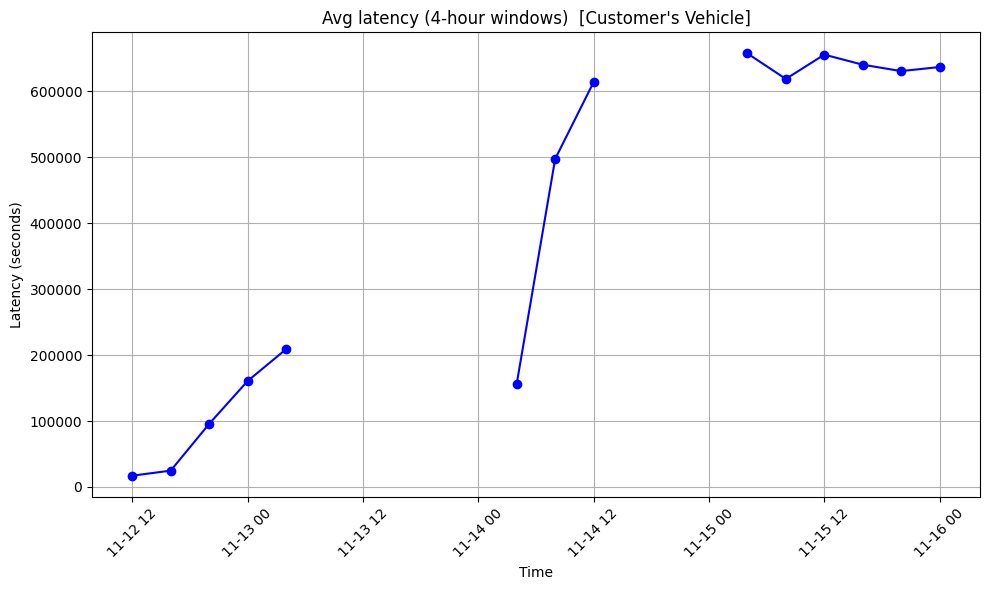

In [41]:
freq_df.set_index('ts_recorded', inplace=True)
window=4
df_resampled = freq_df.resample(f'{window}h').mean()

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(df_resampled.index, df_resampled['latency'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Latency (seconds)')
plt.title(f"Avg latency ({window}-hour windows)  [Customer's Vehicle]")
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#### Tracking Parameters

In [2]:
t_df = pd.read_csv('track_export.csv' , index_col=False)
t_df.drop(['Unnamed: 0', '@vid', '@uid'], axis=1, inplace=True)

In [3]:
t_df['dict_loc']  = t_df.apply(lambda row:  ast.literal_eval(row['track.pos.loc']), axis=1) 

In [4]:
t_df['lat'] = t_df.apply(lambda row:  row['dict_loc']['lat'], axis=1)
t_df['lon'] = t_df.apply(lambda row:  row['dict_loc']['lon'], axis=1)

In [5]:
# Calculate differences between consecutive points
t_df['delta_lat'] = t_df['lat'].diff()
t_df['delta_lon'] = t_df['lon'].diff()

In [6]:
t_df.head()

track.pos.sog  track.pos.cog         @t  \
0              0              0  track.pos   
1              0              0  track.pos   
2              0              0  track.pos   
3              0              0  track.pos   
4              0              0  track.pos   

                        track.pos.loc  track.pos.nsat  track.pos.alt  \
0  {'lat': 42.552503, 'lon': -2.9023}               0              0   
1  {'lat': 42.552503, 'lon': -2.9023}               0              0   
2  {'lat': 42.552503, 'lon': -2.9023}               0              0   
3  {'lat': 42.552503, 'lon': -2.9023}               0              0   
4  {'lat': 42.552503, 'lon': -2.9023}               0              0   

                           @ts                         @rec  \
0  2024-11-21T14:10:07.000000Z  2024-11-25T03:12:37.989639Z   
1  2024-11-21T14:10:07.010000Z  2024-11-25T03:12:38.630291Z   
2  2024-11-21T14:10:07.020000Z  2024-11-25T03:12:38.838670Z   
3  2024-11-21T14:10:07.030000Z  2024-11-25T03:12:39.358317Z   
4  2024-11-21T14:10:07.040000Z  2024-11-25T03:12:39.728956Z   

                             dict_loc        lat     lon  delta_lat  delta_lon  
0  {'lat': 42.552503, 'lon': -2.9023}  42.552503 -2.9023        NaN        NaN  
1  {'lat': 42.552503, 'lon': -2.9023}  42.552503 -2.9023        0.0        0.0  
2  {'lat': 42.552503, 'lon': -2.9023}  42.552503 -2.9023        0.0        0.0  
3  {'lat': 42.552503, 'lon': -2.9023}  42.552503 -2.9023        0.0        0.0  
4  {'lat': 42.552503, 'lon': -2.9023}  42.552503 -2.9023        0.0        0.0

##### Latitude and Longitude

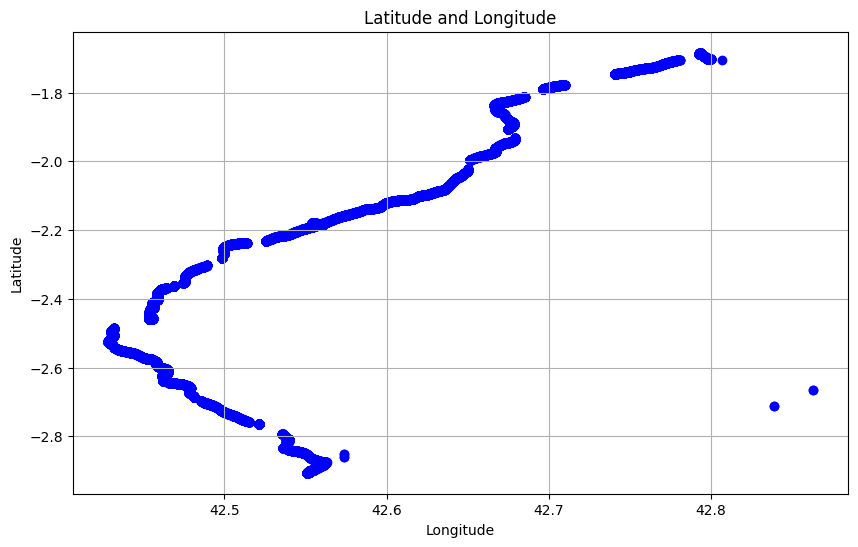

In [9]:
plt.figure(figsize=(10, 6))

plt.scatter(t_df['lat'], t_df['lon'], color='blue', marker='o' )
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude and Longitude')

# Plot the start and end markers
# plt.plot(t_df['lon'].iloc[0], t_df['lat'].iloc[0], 'go', markersize=10, label='Start')  # Start point in green
# plt.plot(t_df['lon'].iloc[-1], t_df['lat'].iloc[-1], 'ro', markersize=10, label='End')  # End point in red

# Display the plot
plt.grid(True)
plt.show()

In [12]:
# Create an interactive scatter plot
fig = px.scatter_geo(t_df, 
                     lat='lat', 
                     lon='lon', 
                     hover_name='@ts',  # Hover over the 'index' column to show index number
                     title="Interactive Latitude and Longitude Plot")

# Show the figure
fig.show()

##### Latitude and Longitude w/direction

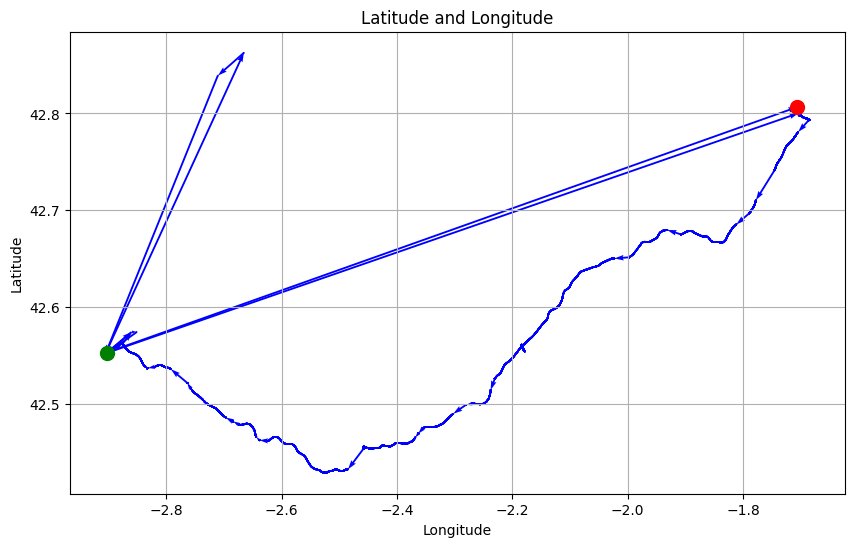

In [30]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the start and end markers
plt.plot(t_df['lon'].iloc[0], t_df['lat'].iloc[0], 'go', markersize=10, label='Start')  # Start point in green
plt.plot(t_df['lon'].iloc[-1], t_df['lat'].iloc[-1], 'ro', markersize=10, label='End')  # End point in red


# Use quiver to plot arrows
# We skip the first row because it has NaN for deltas (no previous point)
plt.quiver(
    t_df['lon'][:-1],  # Starting longitude (x-coordinates)
    t_df['lat'][:-1],   # Starting latitude (y-coordinates)
    t_df['delta_lon'][1:],   # Change in longitude (delta x)
    t_df['delta_lat'][1:],   # Change in latitude (delta y)
    scale_units='xy', angles='xy', scale=1, color='blue'
)


# Set plot labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude and Longitude')

# Display the plot
plt.grid(True)
plt.show()

#### Batch Dataframe 

**Objective**  
What are the tradeoffs between sending data in batches and/or individually ? 

In [25]:
b_df = pd.read_csv('batch_export.csv' , index_col=False)
b_df.drop(['Unnamed: 0', '@vid', '@uid'], axis=1, inplace=True)

In [26]:
b_df.head()

batch.bytes     @t  batch.event_count  batch.bytes_decompressed  \
0            0  batch                  0                         0   
1            0  batch                  0                         0   
2            0  batch                  0                         0   
3            0  batch                  0                         0   
4            0  batch                  0                         0   

   batch.data_count                          @ts                         @rec  
0                 5  2024-11-26T02:00:00.423474Z  2024-11-26T02:00:00.423474Z  
1                 5  2024-11-26T02:00:00.868006Z  2024-11-26T02:00:00.868006Z  
2                 5  2024-11-26T02:00:01.360647Z  2024-11-26T02:00:01.360647Z  
3                 5  2024-11-26T02:00:02.231946Z  2024-11-26T02:00:02.231946Z  
4                 5  2024-11-26T02:00:03.076639Z  2024-11-26T02:00:03.076639Z

#### Events Dataframe

In [26]:
e_df = pd.read_csv('event_export.csv' , index_col=False)
e_df.drop(['Unnamed: 0', '@vid'], axis=1, inplace=True)
e_df["@ts"] = pd.to_datetime(e_df["@ts"])
e_df["@rec"] = pd.to_datetime(e_df["@rec"])

# # Filter data to a specific 1-week period
# start_date = "2024-10-17"
# end_date = "2024-10-20"
# e_df = e_df[(e_df["@ts"] >= start_date) & (e_df["@ts"] < end_date)]

# # Filter event of interest
# e_df = e_df[ e_df['@tag'].str.contains('trip')]

In [27]:
e_df

@uid                           @tag  \
0    9e46cf6b-184d-4d36-a00c-93f062fc26f2                     trip/start   
1    9e46cf6b-184d-4d36-a00c-93f062fc26f2        vehicle/position/moving   
2    9e46cf6b-184d-4d36-a00c-93f062fc26f2    vehicle/position/standstill   
3    9e46cf6b-184d-4d36-a00c-93f062fc26f2                     trip/start   
4    9e46cf6b-184d-4d36-a00c-93f062fc26f2        vehicle/position/moving   
..                                    ...                            ...   
208  9e46cf6b-184d-4d36-a00c-93f062fc26f2   vehicle/battery/overcharging   
209  9e46cf6b-184d-4d36-a00c-93f062fc26f2    vehicle/position/standstill   
210  9e46cf6b-184d-4d36-a00c-93f062fc26f2       vehicle/battery/charging   
211  9e46cf6b-184d-4d36-a00c-93f062fc26f2  vehicle/battery/charging_slow   
212  9e46cf6b-184d-4d36-a00c-93f062fc26f2             system/power/sleep   

                         @t                       @ts  \
0           event.mini.trip 2024-11-11 10:25:39+00:00   
1    event.vehicle.position 2024-11-11 11:04:12+00:00   
2    event.vehicle.position 2024-11-12 07:42:59+00:00   
3           event.mini.trip 2024-11-12 07:55:00+00:00   
4    event.vehicle.position 2024-11-12 12:59:55+00:00   
..                      ...                       ...   
208   event.vehicle.battery 2024-11-20 08:16:04+00:00   
209  event.vehicle.position 2024-11-20 08:50:11+00:00   
210   event.vehicle.battery 2024-11-20 08:50:11+00:00   
211   event.vehicle.battery 2024-11-20 09:50:11+00:00   
212       event.power.sleep 2024-11-20 09:50:11+00:00   

                                @rec  
0   2024-11-11 10:25:41.659550+00:00  
1   2024-11-11 11:04:14.857511+00:00  
2   2024-11-12 07:43:29.645194+00:00  
3   2024-11-12 07:55:02.904616+00:00  
4   2024-11-12 12:59:59.103894+00:00  
..                               ...  
208 2024-11-20 08:16:14.455689+00:00  
209 2024-11-20 08:50:14.321640+00:00  
210 2024-11-20 08:50:14.321640+00:00  
211 2024-11-20 09:51:02.762262+00:00  
212 2024-11-20 09:51:02.762262+00:00  

[213 rows x 5 columns]

In [15]:
# Separate start and stop events
start_df = e_df[e_df["@tag"] == "trip/start"].reset_index(drop=True)
stop_df = e_df[e_df["@tag"] == "trip/stop"].reset_index(drop=True)


# Calculate duration for each trip
start_df["start_time"] = start_df["@ts"]
stop_df["end_time"] = stop_df["@ts"]
trip_durations = pd.DataFrame({
    "start_time": start_df["start_time"],
    "end_time": stop_df["end_time"],
    "duration": (stop_df["end_time"] - start_df["start_time"]).dt.total_seconds() / 60  # Duration in minutes
})


In [16]:
e_df

Empty DataFrame
Columns: [@tag, @t, @ts, @rec]
Index: []

/tmp/ipykernel_9737/1167376401.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


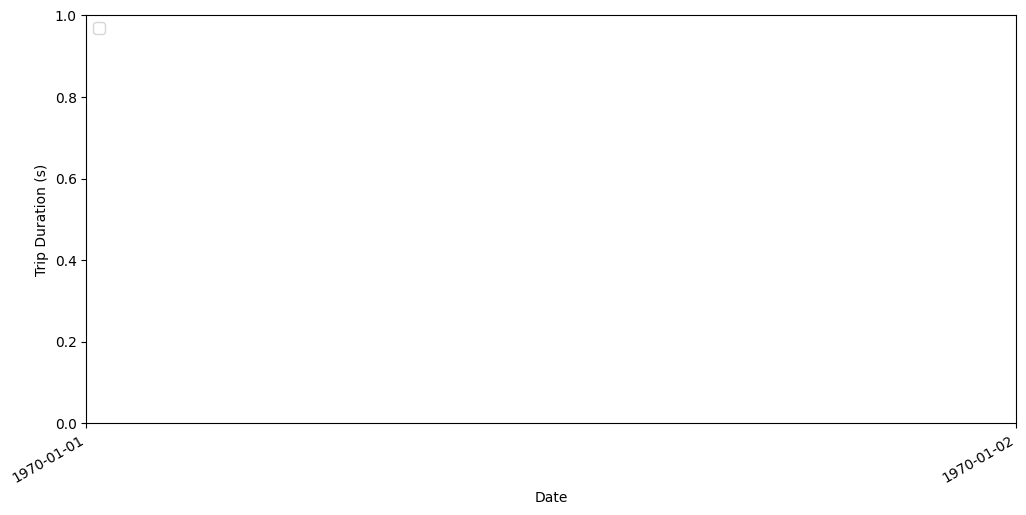

In [11]:
# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each trip as a vertical bar
for idx, row in trip_durations.iterrows():
    # Plot the trip duration as a vertical bar at the trip start time
    ax.bar(row["start_time"], row["duration"], width=0.01, color='skyblue', label="Trip Duration" if idx == 0 else "")
    
    # Plot start and stop markers as small rectangles at the base of each bar
    ax.bar(row["start_time"], 0.05 * row["duration"], width=0.002, color='green', label="Start" if idx == 0 else "")
    ax.bar(row["end_time"], 0.05 * row["duration"], width=0.002, color='red', label="Stop" if idx == 0 else "")

# Format x-axis to show datetime
ax.set_xlabel("Date")
ax.set_ylabel("Trip Duration (s)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
fig.autofmt_xdate()  # Rotate date labels for readability

# Add legend
ax.legend(loc="upper left")

# Show plot
plt.show()

#### OBD parameters Dataframe

In [24]:
o_df = pd.read_csv('obd_export.csv' , index_col=False, low_memory=False)
o_df.drop(['Unnamed: 0', '@vid', '@uid'], axis=1, inplace=True)

In [25]:
o_df.tail()

obd.bat.voltage                          @ts  obd.bat.state  \
96957              NaN  2024-11-27T08:28:18.000000Z            NaN   
96958              NaN  2024-11-27T08:28:18.000000Z            NaN   
96959             13.7  2024-11-27T08:33:18.000000Z            NaN   
96960             13.1  2024-11-27T08:34:31.000000Z            NaN   
96961             13.0  2024-11-27T09:34:31.000000Z            NaN   

       obd.bat.level                                       @t  \
96957            NaN                         obd.coolant_temp   
96958            NaN  obd.oem_hv_battery_min_cell_temperature   
96959            0.0                                  obd.bat   
96960            0.0                                  obd.bat   
96961            0.0                                  obd.bat   

                              @rec  obd.oem_battery_temperature.value  \
96957  2024-11-27T08:28:20.024361Z                                NaN   
96958  2024-11-27T08:28:20.024361Z                                NaN   
96959  2024-11-27T08:33:21.554212Z                                NaN   
96960  2024-11-27T08:34:41.185866Z                                NaN   
96961  2024-11-27T09:36:34.011098Z                                NaN   

       obd.obd_oem_total_mileage.value  \
96957                              NaN   
96958                              NaN   
96959                              NaN   
96960                              NaN   
96961                              NaN   

       obd.oem_hv_battery_max_cell_temperature.value  \
96957                                            NaN   
96958                                            NaN   
96959                                            NaN   
96960                                            NaN   
96961                                            NaN   

       obd.oem_battery_charge_level.value  ...  \
96957                                 NaN  ...   
96958                                 NaN  ...   
96959                                 NaN  ...   
96960                                 NaN  ...   
96961                                 NaN  ...   

      obd.oem_hv_battery_max_cell_voltage.value  \
96957                                       NaN   
96958                                       NaN   
96959                                       NaN   
96960                                       NaN   
96961                                       NaN   

       obd.oem_hv_battery_current.value  obd.oem_hv_battery_voltage.value  \
96957                               NaN                               NaN   
96958                               NaN                               NaN   
96959                               NaN                               NaN   
96960                               NaN                               NaN   
96961                               NaN                               NaN   

       obd.oem_hv_battery_max_energy.value  \
96957                                  NaN   
96958                                  NaN   
96959                                  NaN   
96960                                  NaN   
96961                                  NaN   

       obd.oem_hv_battery_measured_energy.value  \
96957                                       NaN   
96958                                       NaN   
96959                                       NaN   
96960                                       NaN   
96961                                       NaN   

       obd.oem_hv_battery_lifetime_power_use.value  \
96957                                          NaN   
96958                                          NaN   
96959                                          NaN   
96960                                          NaN   
96961                                          NaN   

       obd.oem_hv_battery_lifetime_charge_power.value  \
96957                                             NaN   
96958                                             NaN   
96959          

In [34]:
o_df.columns

Index(['obd.bat.voltage', '@ts', 'obd.bat.state', 'obd.bat.level', '@t',
       '@rec', 'obd.oem_battery_temperature.value',
       'obd.obd_oem_total_mileage.value',
       'obd.oem_hv_battery_max_cell_temperature.value',
       'obd.oem_battery_charge_level.value',
       'obd.oem_battery_charge_state.value', 'obd.number_of_dtc.value',
       'obd.hybrid_system_voltage.value', 'obd.rpm.value', 'obd.speed.value',
       'obd.engine_load.value', 'obd.throttle_pos.value',
       'obd.control_module_voltage.value',
       'obd.hybrid_battery_pack_life.value', 'obd.hybrid_system_current.value',
       'obd.oem_hv_battery_min_cell_voltage.value',
       'obd.oem_hv_battery_max_cell_voltage.value',
       'obd.oem_hv_battery_current.value', 'obd.oem_hv_battery_voltage.value',
       'obd.oem_hv_battery_max_energy.value',
       'obd.oem_hv_battery_measured_energy.value',
       'obd.oem_hv_battery_lifetime_power_use.value',
       'obd.oem_hv_battery_lifetime_charge_power.value',
       'ob

In [27]:
obd_all_cols = filter( lambda x: '@' not in x, o_df.columns.to_list())

In [ ]:
#o_df[ o_df['obd.oem_battery_state_of_health.value'].notna() == True ][['@ts','obd.oem_battery_state_of_health.value']].to_csv('battery_soh.csv', index=False)

In [28]:
# Figure out which columns cannot be directly plotted 
obd_cols_numeric = list(set(obd_all_cols).intersection(set(o_df.describe().columns)))
obd_cols_categorical =  list( set(obd_all_cols) - set(o_df.describe().columns) )

In [29]:
o_df['@ts'] = pd.to_datetime(o_df['@ts'])

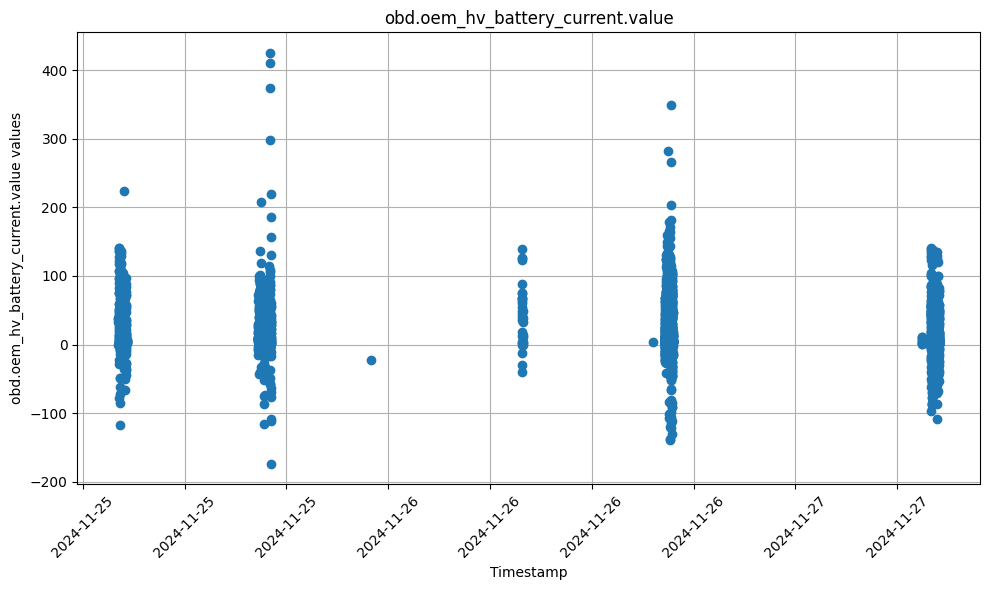

In [35]:
plot_column(o_df, 'obd.oem_hv_battery_current.value')

In [41]:
o_df['@t'].unique()

array(['obd.bat', 'obd.oem_battery_temperature',
       'obd.obd_oem_total_mileage',
       'obd.oem_hv_battery_max_cell_temperature',
       'obd.oem_battery_charge_level', 'obd.oem_battery_charge_state',
       'obd.number_of_dtc', 'obd.hybrid_system_voltage', 'obd.rpm',
       'obd.speed', 'obd.engine_load', 'obd.throttle_pos',
       'obd.control_module_voltage', 'obd.hybrid_battery_pack_life',
       'obd.hybrid_system_current', 'obd.oem_hv_battery_min_cell_voltage',
       'obd.oem_hv_battery_max_cell_voltage',
       'obd.oem_hv_battery_current', 'obd.oem_hv_battery_voltage',
       'obd.oem_hv_battery_max_energy',
       'obd.oem_hv_battery_measured_energy',
       'obd.oem_hv_battery_lifetime_power_use',
       'obd.oem_hv_battery_lifetime_charge_power',
       'obd.oem_remaining_distance', 'obd.coolant_temp',
       'obd.oem_hv_battery_min_cell_temperature'], dtype=object)

In [45]:
o_df[ (o_df['@ts'] >= str(datetime(2024, 11, 20))) & (o_df['@ts'] < str(datetime(2024, 11, 27))) 
     & (df['@t'] == 'obd.oem_hv_battery_current')]

Empty DataFrame
Columns: [obd.bat.voltage, @ts, obd.bat.state, obd.bat.level, @t, @rec, obd.oem_battery_temperature.value, obd.obd_oem_total_mileage.value, obd.oem_hv_battery_max_cell_temperature.value, obd.oem_battery_charge_level.value, obd.oem_battery_charge_state.value, obd.number_of_dtc.value, obd.hybrid_system_voltage.value, obd.rpm.value, obd.speed.value, obd.engine_load.value, obd.throttle_pos.value, obd.control_module_voltage.value, obd.hybrid_battery_pack_life.value, obd.hybrid_system_current.value, obd.oem_hv_battery_min_cell_voltage.value, obd.oem_hv_battery_max_cell_voltage.value, obd.oem_hv_battery_current.value, obd.oem_hv_battery_voltage.value, obd.oem_hv_battery_max_energy.value, obd.oem_hv_battery_measured_energy.value, obd.oem_hv_battery_lifetime_power_use.value, obd.oem_hv_battery_lifetime_charge_power.value, obd.oem_remaining_distance.value, obd.coolant_temp.value, obd.oem_hv_battery_min_cell_temperature.value]
Index: []

[0 rows x 31 columns]

In [53]:
o_df[ o_df['@ts'] >= '2024-11-26 00:55:10+00:00' ]

obd.bat.voltage                       @ts  obd.bat.state  \
22848             12.9 2024-11-26 01:55:09+00:00            NaN   
22849             12.8 2024-11-26 02:55:09+00:00            NaN   
22850             12.8 2024-11-26 03:55:09+00:00            NaN   
22851             12.8 2024-11-26 04:55:09+00:00            NaN   
22852             12.8 2024-11-26 05:55:09+00:00            NaN   
...                ...                       ...            ...   
96957              NaN 2024-11-27 08:28:18+00:00            NaN   
96958              NaN 2024-11-27 08:28:18+00:00            NaN   
96959             13.7 2024-11-27 08:33:18+00:00            NaN   
96960             13.1 2024-11-27 08:34:31+00:00            NaN   
96961             13.0 2024-11-27 09:34:31+00:00            NaN   

       obd.bat.level                                       @t  \
22848            0.0                                  obd.bat   
22849            0.0                                  obd.bat   
22850            0.0                                  obd.bat   
22851            0.0                                  obd.bat   
22852            0.0                                  obd.bat   
...              ...                                      ...   
96957            NaN                         obd.coolant_temp   
96958            NaN  obd.oem_hv_battery_min_cell_temperature   
96959            0.0                                  obd.bat   
96960            0.0                                  obd.bat   
96961            0.0                                  obd.bat   

                              @rec  obd.oem_battery_temperature.value  \
22848  2024-11-26T01:57:14.618276Z                                NaN   
22849  2024-11-26T02:57:21.162602Z                                NaN   
22850  2024-11-26T03:57:28.208740Z                                NaN   
22851  2024-11-26T04:55:34.632614Z                                NaN   
22852  2024-11-26T05:55:40.638523Z                                NaN   
...                            ...                                ...   
96957  2024-11-27T08:28:20.024361Z                                NaN   
96958  2024-11-27T08:28:20.024361Z                                NaN   
96959  2024-11-27T08:33:21.554212Z                                NaN   
96960  2024-11-27T08:34:41.185866Z                                NaN   
96961  2024-11-27T09:36:34.011098Z                                NaN   

       obd.obd_oem_total_mileage.value  \
22848                              NaN   
22849                              NaN   
22850                              NaN   
22851                              NaN   
22852                              NaN   
...                                ...   
96957                              NaN   
96958                              NaN   
96959                              NaN   
96960                              NaN   
96961                              NaN   

       obd.oem_hv_battery_max_cell_temperature.value  \
22848                                            NaN   
22849                                            NaN   
22850                                            NaN   
22851                                            NaN   
22852                                            NaN   
...                                              ...   
96957                                            NaN   
96958                                            NaN   
96959                                            NaN   
96960                                            NaN   
96961                                            NaN   

       obd.oem_battery_charge_level.value  ...  \
22848                                 NaN  ...   
22849                                 NaN  ...   
22850                                 NaN  ...   
22851                                 NaN  ...   
22852                                 NaN  ...   
...                                   ...  ...   
96957           

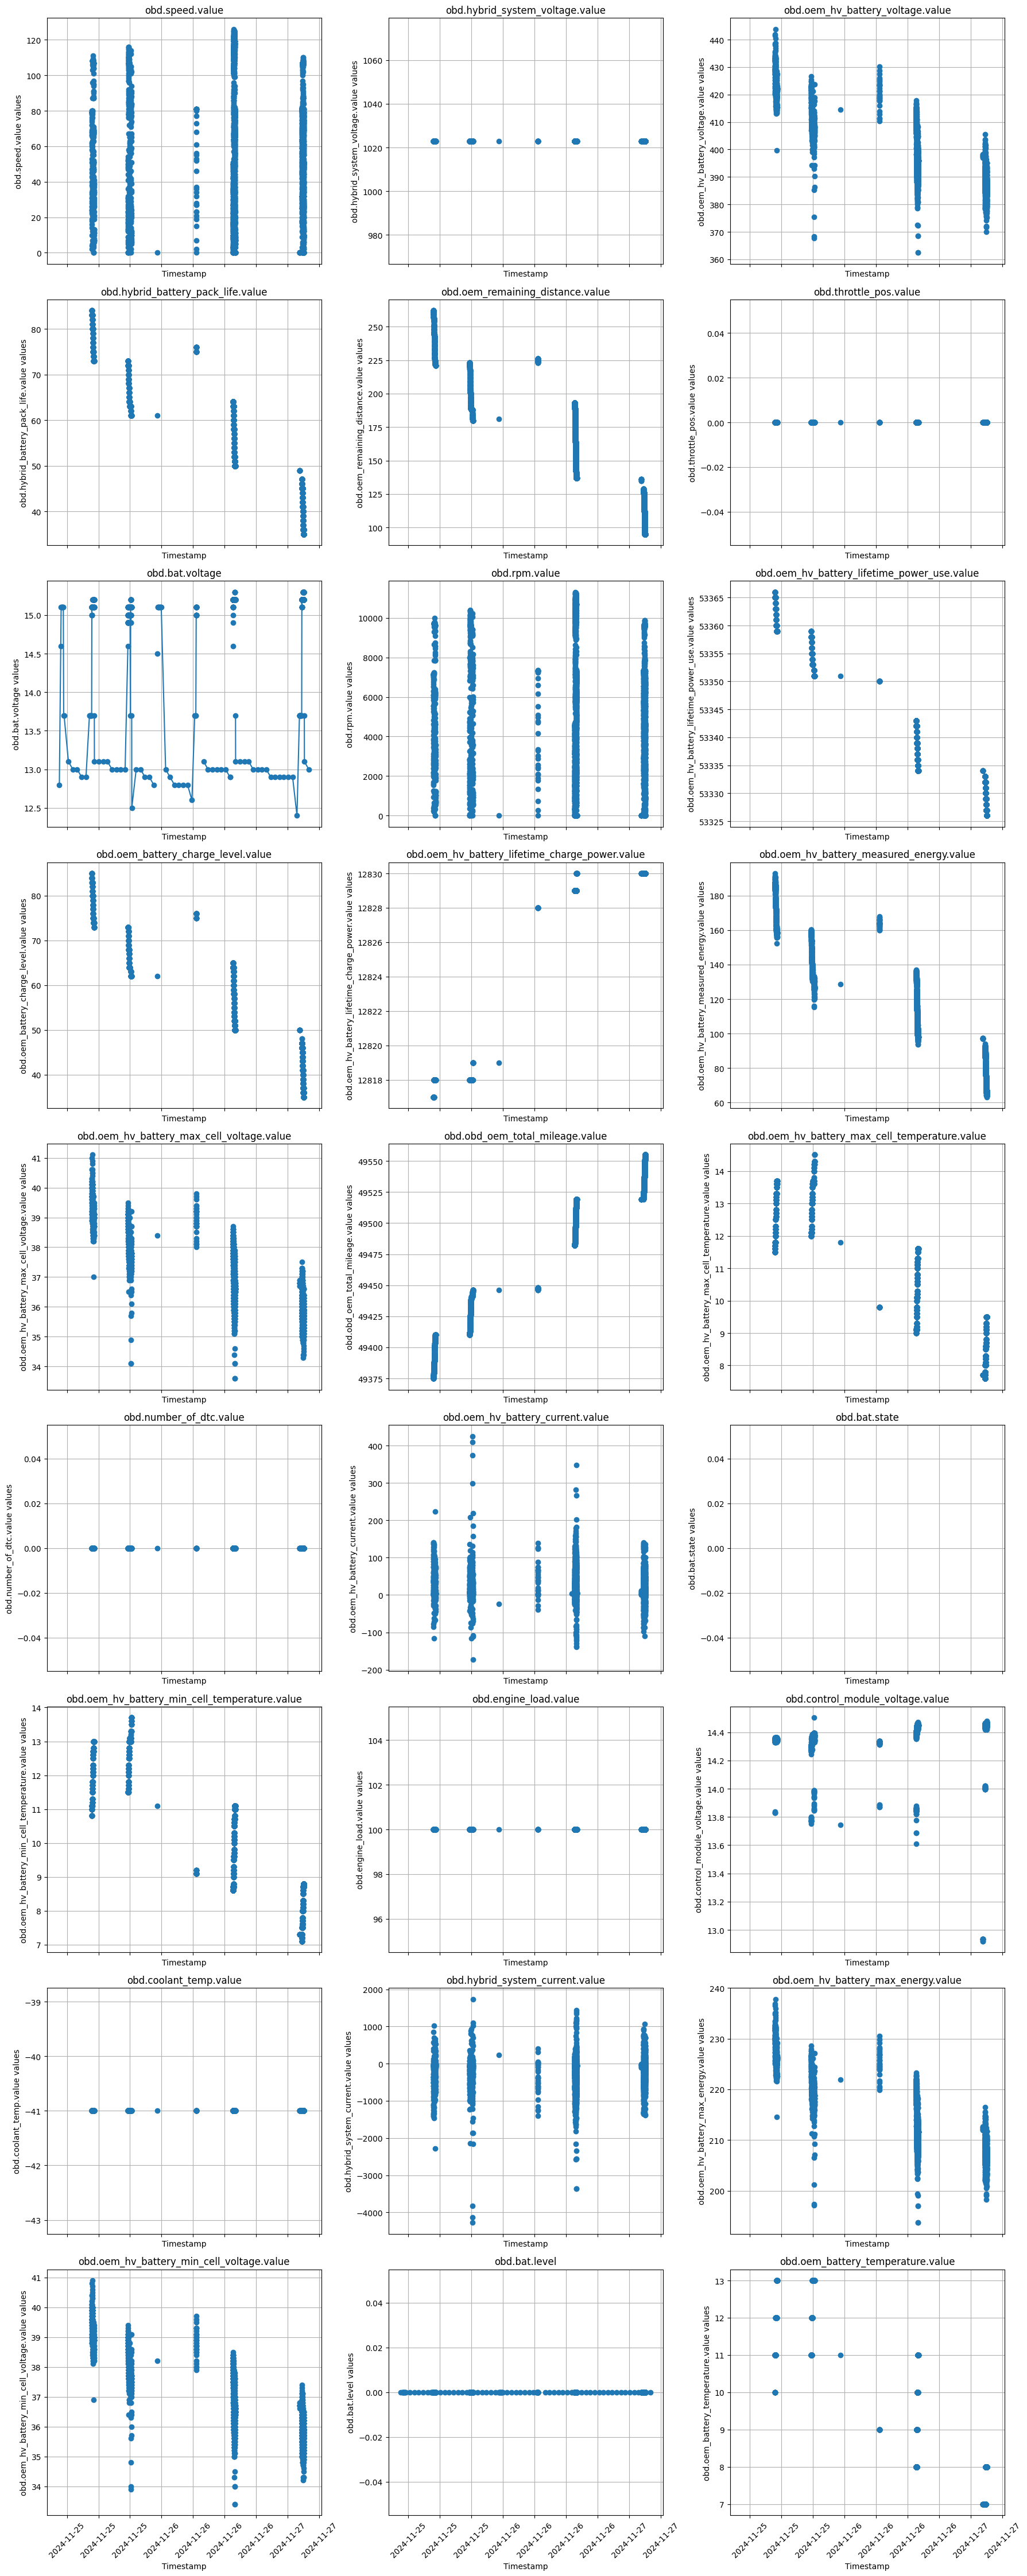

In [31]:
plot_grid(o_df, obd_cols_numeric)

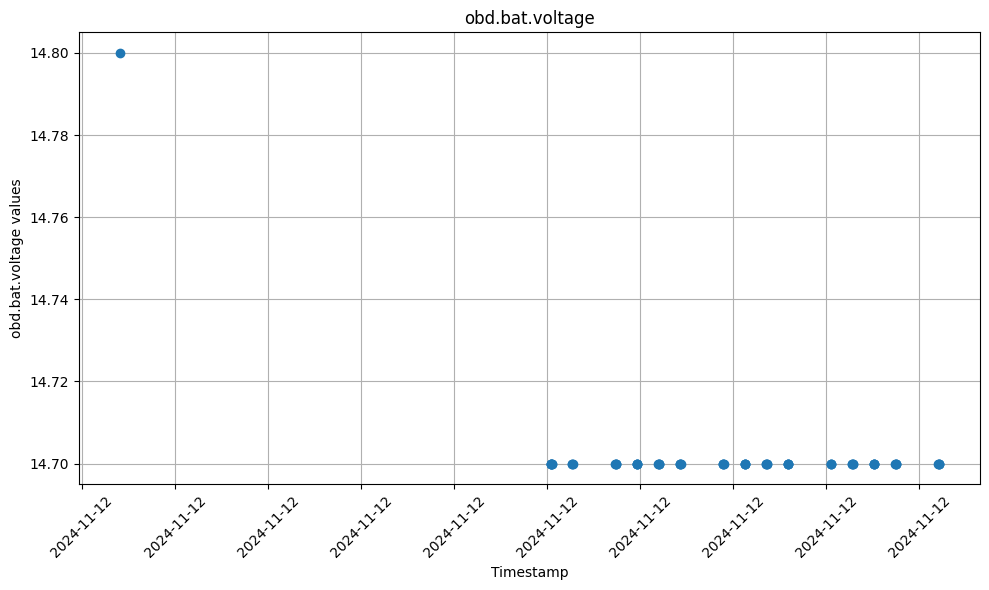

In [30]:
plot_column(o_df, 'obd.bat.voltage')

#### STD parameters Dataframe

In [4]:
s_df = pd.read_csv('./std_export.csv' , index_col=False)
s_df.drop(['Unnamed: 0', '@vid', '@uid'], axis=1, inplace=True)

In [5]:
len(s_df)

88394

In [6]:
s_all_cols = list(filter(lambda x: '@' not in x, s_df.columns.to_list()))

In [7]:
s_cols = list(set(s_all_cols).intersection(set(s_df.describe().columns)))

In [8]:
s_cols_complement =  list(set(s_all_cols) - set(s_df.describe().columns))

In [9]:
for col in s_cols_complement:
    print(s_df[col].value_counts())

std.movement.value
on     3810
off      52
Name: count, dtype: int64
std.ignition.value
on     3810
off      52
Name: count, dtype: int64
std.bt_status.value
bt-is-disabled    3862
Name: count, dtype: int64
std.data_mode.value
unknown-on-moving    3810
unknown-on-stop        52
Name: count, dtype: int64
std.gnss_status.value
gnss-on-with-fix       3744
gnss-on-without-fix      70
gnss-sleep               48
Name: count, dtype: int64


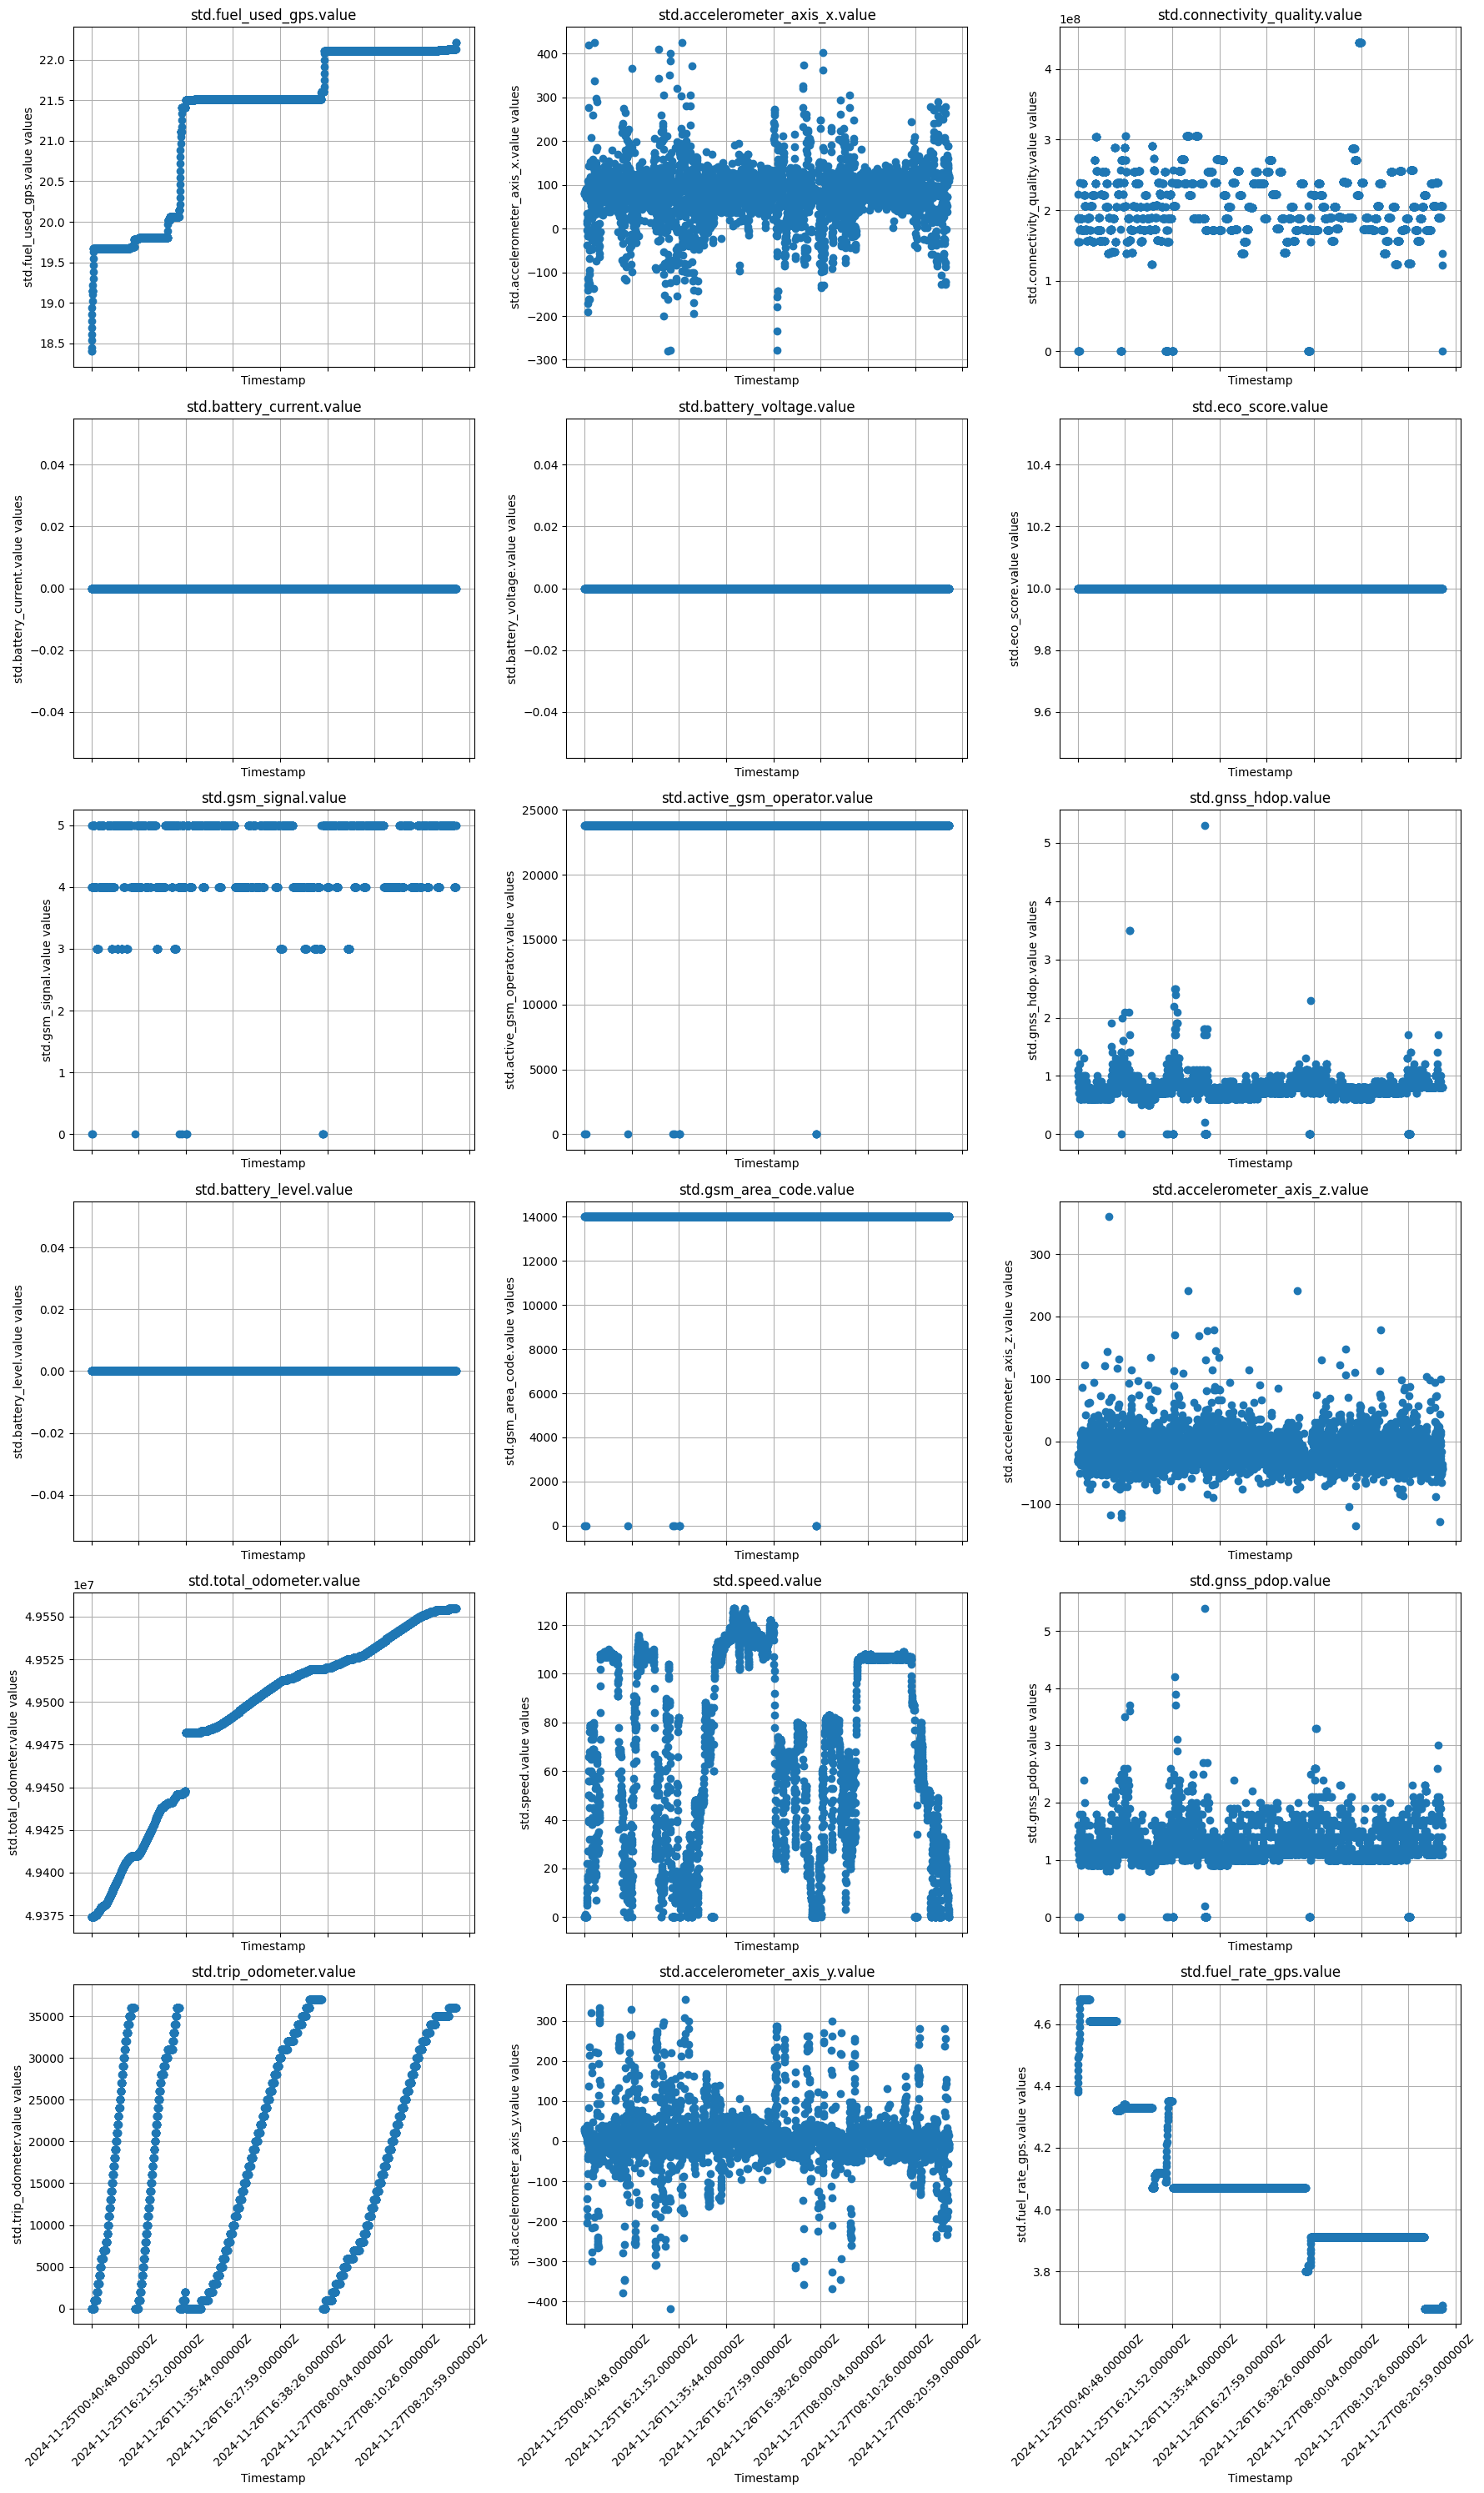

In [13]:
plot_grid(s_df, s_cols)

In [75]:
s_cols

['std.gnss_pdop.value', 'std.gnss_hdop.value', 'std.trip_odometer.value']

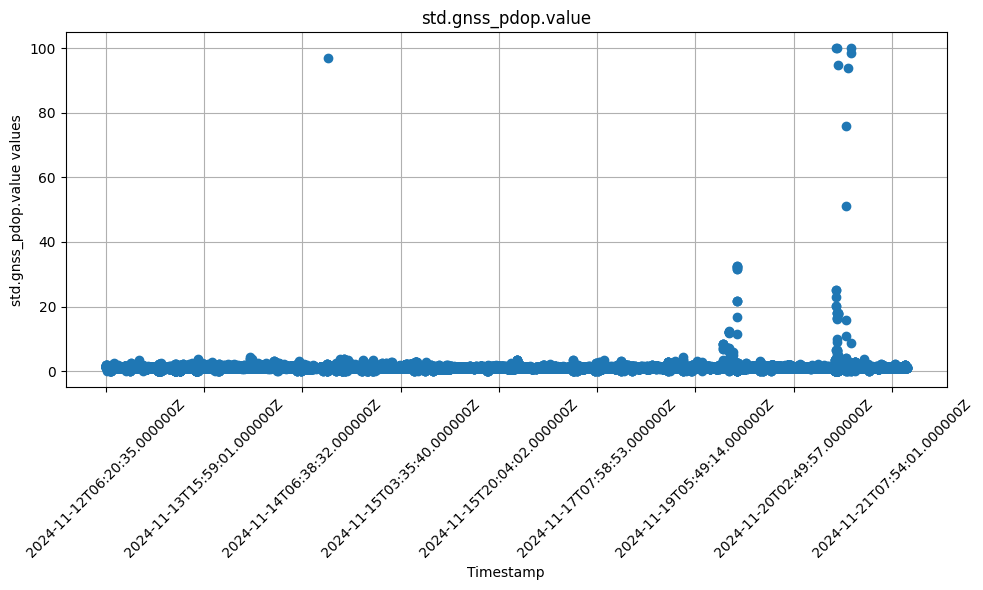

In [76]:
plot_column(s_df,'std.gnss_pdop.value')